In [1]:
%reload_ext autoreload
%autoreload 2

In [208]:
from ripple_heterogeneity.utils import (
    functions,
    loading,
    add_new_deep_sup,
)
from ripple_heterogeneity.replay import replay_run
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import nelpy as nel
from matplotlib.ticker import AutoMinorLocator
from tqdm import tqdm
import scipy.stats as stats
from scipy.signal import gaussian
import scipy.signal as scs
import itertools


In [3]:
functions.set_plotting_defaults()
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
fig_save_path = r'Z:\home\ryanh\projects\ripple_heterogeneity\figures\panels'

In [4]:
save_path = r'Z:\home\ryanh\projects\ripple_heterogeneity\replay'

df = replay_run.load_results(save_path)

In [5]:
df = df[(df.decoding_r2_pval < 0.05) & (df.decoding_median_error < 30)]


Text(0, 0.5, 'ripples')

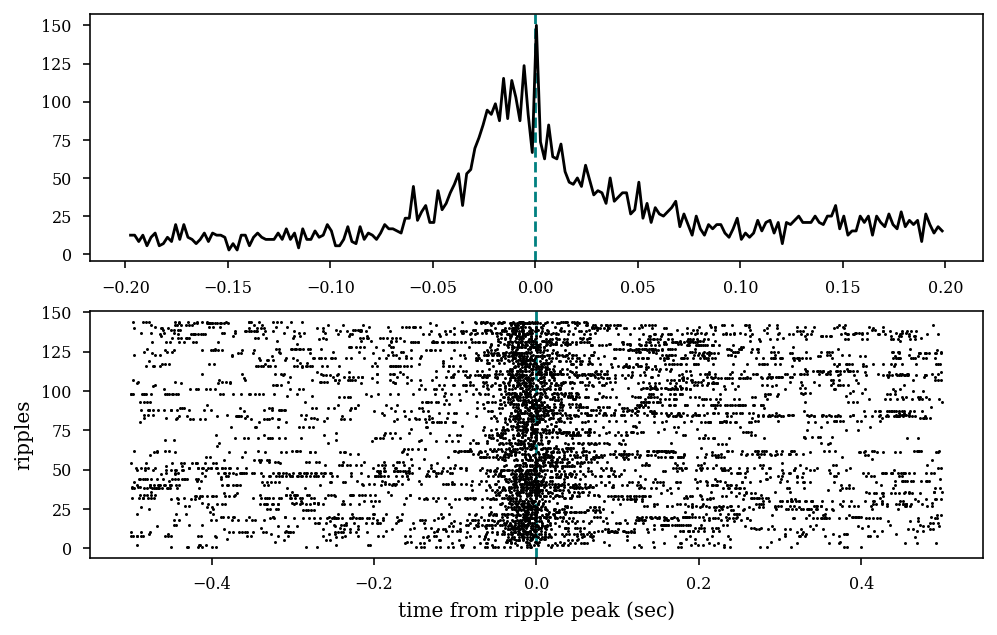

In [227]:
def get_raster_points(spikes,peak_time):
    ''' 
    create raster centered over each ripple with a 1 second window
    '''
    x = []
    y = []
    for i,r in enumerate(peak_time):
        idx = (spikes> r - .5) & (spikes < r + .5)
        cur_spks = spikes[idx]
        if any(cur_spks):
            x.append(cur_spks - r)
            y.append(np.ones_like(cur_spks)+i)       
    x = list(itertools.chain(*x))
    y = list(itertools.chain(*y))
    return x, y

x,y = get_raster_points(st_deep.data, ripple_peaks)

# x,y = get_raster_points(st_deep.data, ripple_peakss)
h0_counts, bin_edges = np.histogram(x, bins=np.arange(-0.2,0.2,0.002))
fr = h0_counts / (len(np.unique(y))*0.005)

fig,ax = plt.subplots(2,1,figsize=(8,5))
ax[1].plot(x,y,'.k',markersize=3)
ax[0].plot(bin_edges[:-1]+0.005/2,fr,color='k')
ax[0].axvline(0,zorder=-1000,linestyle="--",color='teal')
ax[1].axvline(0,zorder=-1000,linestyle="--",color='teal')
ax[1].set_xlabel('time from ripple peak (sec)')
ax[1].set_ylabel('ripples')

# ax[0].set_ylabel('n dentate spikes (D2)')

In [ ]:
df.score_pval_col_cycle

In [239]:
bin_width = 0.002
n_bins = 200
times = np.linspace(-(n_bins * bin_width) / 2, (n_bins * bin_width) / 2, n_bins + 1)
psth_sup_rip = pd.DataFrame(index=times, columns=np.arange(1))
psth_deep_rip = psth_sup_rip.copy()
psth_sup_replay = psth_sup_rip.copy()
psth_deep_replay = psth_sup_rip.copy()

for basepath in tqdm(df.basepath.unique()):
    # basepath = df.basepath.unique()[0]
    st, cm = loading.load_spikes(basepath, putativeCellType="Pyr", brainRegion="CA1")
    cm = add_new_deep_sup.deep_sup_from_deepSuperficialDistance(cm)

    if "tags_bad_waveform" in cm.columns:
        st._data = st.data[cm.tags_bad_waveform == False]
        cm = cm[cm.tags_bad_waveform == False]

    replay_peaks = df[(df.basepath == basepath) & (df.score_pval_time_swap <= 0.05)].peaks.values
    ripple_peaks = df[(df.basepath == basepath) & (df.score_pval_time_swap > 0.05)].peaks.values

    if (cm.deepSuperficial == "Deep").any():
        st_deep = nel.SpikeTrainArray(
            timestamps=np.sort(np.hstack(st.data[cm.deepSuperficial == "Deep"])),
            fs=st.fs,
        )
        psth_deep_rip = pd.concat(
            [
                psth_deep_rip,
                functions.compute_psth(st_deep.data, ripple_peaks, n_bins=n_bins),
            ],
            axis=1,
        )
        psth_deep_replay = pd.concat(
            [
                psth_deep_replay,
                functions.compute_psth(st_deep.data, replay_peaks, n_bins=n_bins),
            ],
            axis=1,
        )

    if (cm.deepSuperficial == "Superficial").any():
        st_sup = nel.SpikeTrainArray(
            timestamps=np.sort(np.hstack(st.data[cm.deepSuperficial == "Superficial"])),
            fs=st.fs,
        )
        psth_sup_rip = pd.concat(
            [
                psth_sup_rip,
                functions.compute_psth(st_sup.data, ripple_peaks, n_bins=n_bins),
            ],
            axis=1,
        )
        psth_sup_replay = pd.concat(
            [
                psth_sup_replay,
                functions.compute_psth(st_sup.data, replay_peaks, n_bins=n_bins),
            ],
            axis=1,
        )


100%|██████████| 64/64 [05:18<00:00,  4.98s/it]


In [138]:
# psth_deep_rip = psth_deep_rip.dropna(axis=1, how="all")
# psth_deep_replay = psth_deep_replay.dropna(axis=1, how="all")
# psth_sup_rip = psth_sup_rip.dropna(axis=1, how="all")
# psth_sup_replay = psth_sup_replay.dropna(axis=1, how="all")



In [166]:
# def hollow_kernel(kernlen, width, hollow_fraction=0.6, kerntype='gaussian'):
#     '''
#     Returns a hollow kernel normalized to it's sum
#     Parameters
#     ----------
#     kernlen : int
#         Length of kernel, must be uneven (kernlen % 2 == 1)
#     width : float
#         Width of kernel (std if gaussian)
#     hollow_fraction : float
#         Fractoin of the central bin to removed.
#     Returns
#     -------
#     kernel : array
#     Authors
#     -------
#     Tristan Stoeber, Mikkel Lepperød
#     '''
#     if kerntype == 'gaussian':
#         assert kernlen % 2 == 1
#         kernel = gaussian(kernlen, width)
#         kernel[int(kernlen / 2.)] *= (1 - hollow_fraction)
#     else:
#         raise NotImplementedError
#     return kernel / sum(kernel)

# def cch_convolve(cch, width, hollow_fraction, kerntype):
    
#     kernlen = len(cch) - 2
#     kernel = hollow_kernel(kernlen, width, hollow_fraction, kerntype)
#     # padd edges
#     len_padd = int(kernlen / 2.)
#     cch_padded = np.zeros(len(cch) + 2 * len_padd)
#     # "firstW/2 bins (excluding the very first bin) are duplicated,
#     # reversed in time, and prepended to the cch prior to convolving"
#     cch_padded[0:len_padd] = cch[1:len_padd+1][::-1]
#     cch_padded[len_padd: - len_padd] = cch
#     # # "Likewise, the lastW/2 bins aresymmetrically appended to the cch."
#     cch_padded[-len_padd:] = cch[-len_padd-1:-1][::-1]
#     # convolve cch with kernel
#     result = scs.fftconvolve(cch_padded, kernel, mode='valid')
#     assert len(cch) == len(result)
#     return result

In [173]:
# ccg = cch_convolve(psth_deep_rip.iloc[:,0].values, 25, .6, 'gaussian')
# plt.plot(psth_deep_rip.iloc[:,0].values - ccg)

In [207]:
# psth_deep_rip = stats.zscore(psth_deep_rip,axis=0)
# psth_deep_replay = stats.zscore(psth_deep_replay,axis=0)
# psth_sup_rip = stats.zscore(psth_sup_rip,axis=0)
# psth_sup_replay = stats.zscore(psth_sup_replay,axis=0)



Text(0.5, 1.0, 'replay psth')

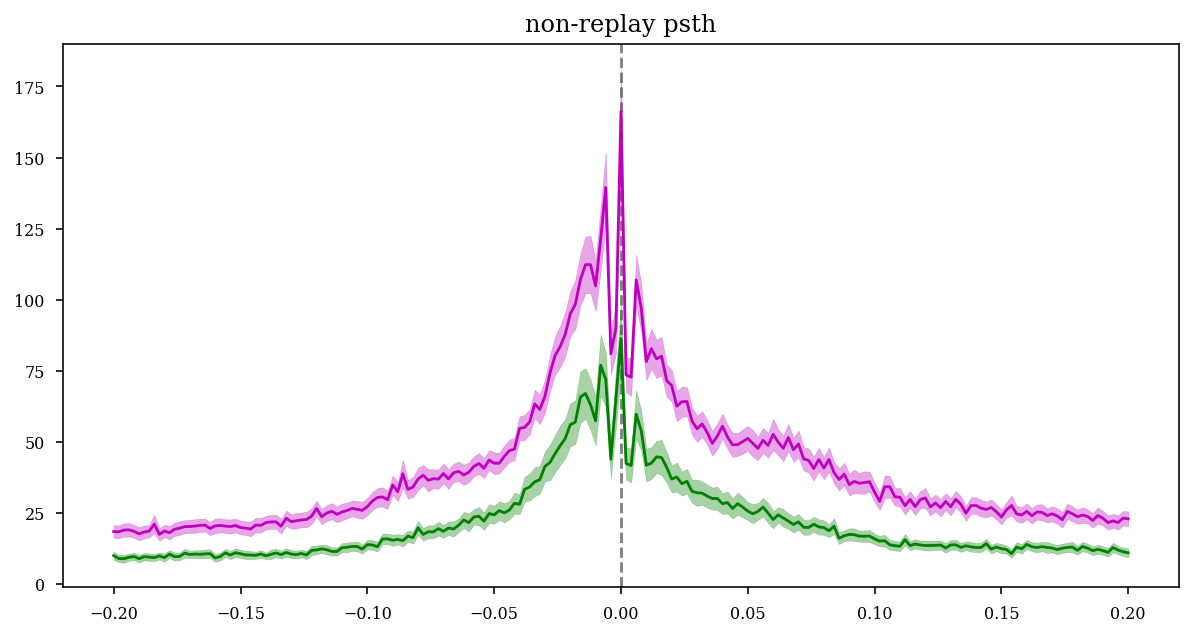

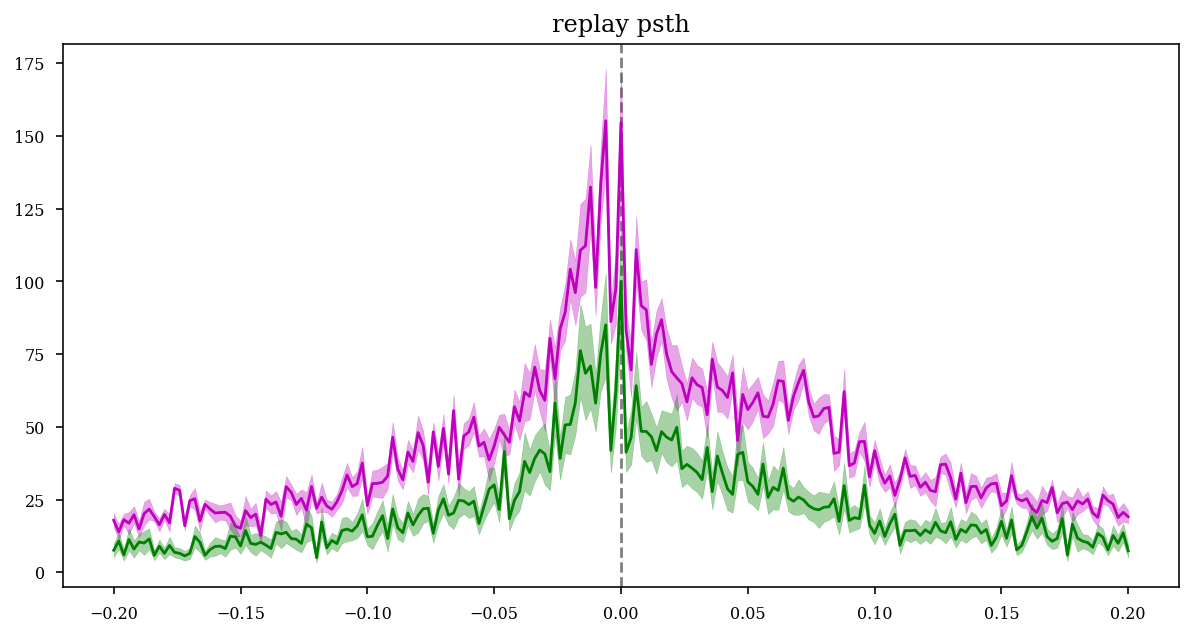

In [237]:
plt.figure(figsize=(10,5))

ax = plt.gca()
psth_deep_rip.mean(axis=1).plot(ax=ax, color="m", label="Deep")
sem = psth_deep_rip.std(axis=1) / np.sqrt(psth_deep_rip.shape[1])
ax.fill_between(
    psth_deep_rip.index,
    psth_deep_rip.mean(axis=1) - sem,
    psth_deep_rip.mean(axis=1) + sem,
    alpha=0.35,
    color="m",
)
psth_sup_rip.mean(axis=1).plot(ax=ax, color="g", label="Superficial")
sem = psth_sup_rip.std(axis=1) / np.sqrt(psth_sup_rip.shape[1])
ax.fill_between(
    psth_sup_rip.index,
    psth_sup_rip.mean(axis=1) - sem,
    psth_sup_rip.mean(axis=1) + sem,
    alpha=0.35,
    color="g",
)
ax.axvline(0, color="k", linestyle="--",alpha=.5,zorder=-100)
ax.set_title('non-replay psth',fontsize=12)


plt.figure(figsize=(10,5))
ax = plt.gca()
psth_deep_replay.mean(axis=1).plot(ax=ax, color="m", label="Deep")
sem = psth_sup_replay.std(axis=1) / np.sqrt(psth_sup_replay.shape[1])
ax.fill_between(
    psth_deep_replay.index,
    psth_deep_replay.mean(axis=1) - sem,
    psth_deep_replay.mean(axis=1) + sem,
    alpha=0.35,
    color="m",
)
psth_sup_replay.mean(axis=1).plot(ax=ax, color="g", label="Superficial")
sem = psth_sup_replay.std(axis=1) / np.sqrt(psth_sup_replay.shape[1])
ax.fill_between(
    psth_sup_replay.index,
    psth_sup_replay.mean(axis=1) - sem,
    psth_sup_replay.mean(axis=1) + sem,
    alpha=0.35,
    color="g",
)
ax.axvline(0, color="k", linestyle="--",alpha=.5,zorder=-100)
ax.set_title('replay psth',fontsize=12)

Text(0, 0.5, 'replay - non-replay')

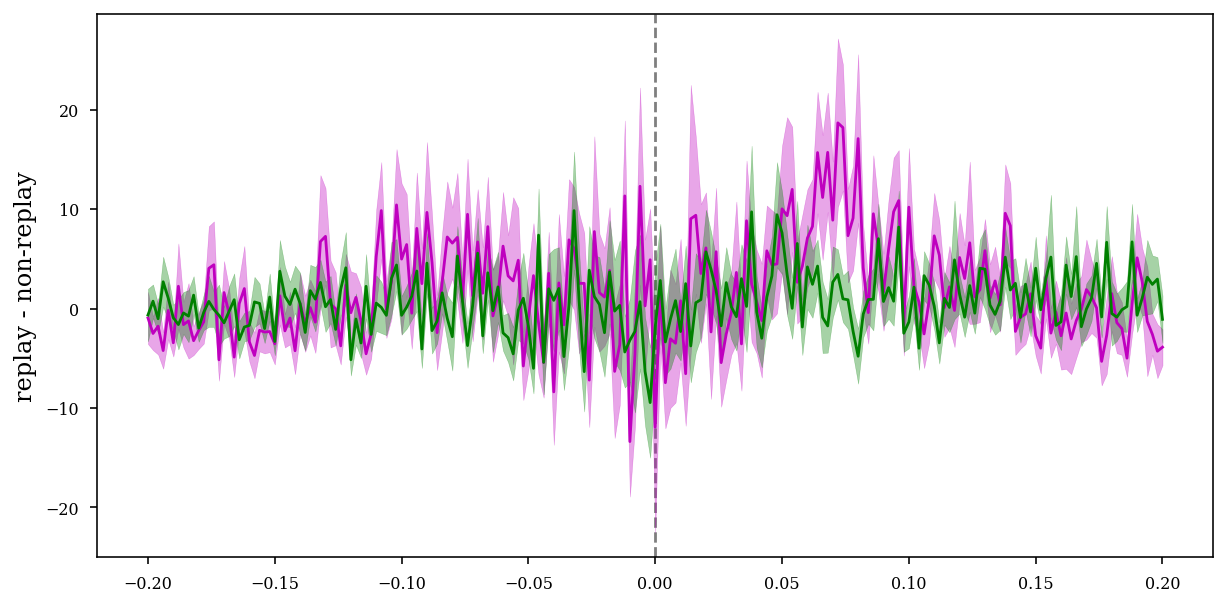

In [241]:
replay_minus_ripple_deep = psth_deep_replay - psth_deep_rip
replay_minus_ripple_sup = psth_sup_replay - psth_sup_rip

plt.figure(figsize=(10,5))

ax = plt.gca()
replay_minus_ripple_deep.mean(axis=1).plot(ax=ax, color="m", label="Deep")
sem = replay_minus_ripple_deep.std(axis=1) / np.sqrt(replay_minus_ripple_deep.shape[1])
ax.fill_between(
    replay_minus_ripple_deep.index,
    replay_minus_ripple_deep.mean(axis=1) - sem,
    replay_minus_ripple_deep.mean(axis=1) + sem,
    alpha=0.35,
    color="m",
)
replay_minus_ripple_sup.mean(axis=1).plot(ax=ax, color="g", label="Superficial")
sem = replay_minus_ripple_sup.std(axis=1) / np.sqrt(replay_minus_ripple_sup.shape[1])
ax.fill_between(
    replay_minus_ripple_sup.index,
    replay_minus_ripple_sup.mean(axis=1) - sem,
    replay_minus_ripple_sup.mean(axis=1) + sem,
    alpha=0.35,
    color="g",
)
ax.axvline(0, color="k", linestyle="--",alpha=.5,zorder=-100)
ax.set_ylabel('replay - non-replay',fontsize=12)